# Pythagorean Won Loss Formula Notebook

Initial setup

In [1]:
try:
    import google.colab
    import requests
    exec(requests.get("https://raw.githubusercontent.com/Something-Else-Studio/arcticdb-notebooks/main/styling.py").text)
    dataFile = 'https://raw.githubusercontent.com/Something-Else-Studio/arcticdb-notebooks/main/pythagorean-won-loss-formula/sports.csv'
except ImportError:
    %load_ext autoreload
    %autoreload 2
    import sys, os
    sys.path.append(os.path.dirname(os.getcwd()))
    from styling import *
    dataFile = "sports.csv"

In [2]:
%pip -q install arcticdb pandas numpy statsmodels seaborn matplotlib plotly scikit-learn
import arcticdb as adb
adb.__version__

Note: you may need to restart the kernel to use updated packages.


'6.1.0'

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# Setup custom chart styling instead of sns.set_theme()
chart_colors = setup_chart_styling()
colors = setup_plotly_theme()

In [4]:
df = pd.read_csv(dataFile)

In [5]:
df = df.drop(columns="Unnamed: 0")
df = df.rename(columns={'FREQ_RUNS_S': 'PS',
                        'FREQ_RUNS_A': 'PA' })

df = df.sort_values(['LEAGUE','YEAR_ID','TEAM_ID'])
styled = style_table(df.head())
export_table_html(styled, "basic_data.html")
styled

Exported: basic_data.html


YEAR_ID,TEAM_ID,OPP_TEAM_ID,PS,PA,date,home,wi,LEAGUE
1897,Carlton,Fitzroy,16,49,1897-05-08,0,0.000000,AFL
1897,Carlton,South Melbourne,36,40,1897-05-15,0,0.000000,AFL
1897,Carlton,Essendon,41,78,1897-05-24,0,0.000000,AFL
1897,Carlton,Geelong,22,44,1897-05-29,0,0.000000,AFL
1897,Carlton,Melbourne,26,107,1897-06-05,0,0.000000,AFL


In [6]:
arctic = adb.Arctic('lmdb://sports')
lib = arctic.get_library('leagues', create_if_missing=True)
for league in df['LEAGUE'].unique():
    lib.write(league, df[df['LEAGUE']==league])
lib.list_symbols()

['IPL', 'MLB', 'EPL', 'SUP', 'LAX', 'AFL', 'NBA', 'NFL', 'NHL']

In [7]:
def ols_coef (df, xcol, ycol):
    """simple OLS function used for lambda calcs -- assumes univariate regression"""
    model=sm.OLS(df[ycol],sm.add_constant(df[xcol])).fit()    

    outdf = pd.DataFrame({'adj.'    : model.params.iloc[0],
                          'adj. se' : model.bse.iloc[0],
                          'λ'    : model.params.iloc[1],
                          'λ se' : model.bse.iloc[1],
                          'nobs' : model.nobs,
                          'adj. $R^2$': model.rsquared_adj}, index=[0])    

    return outdf

Our study period is from 2010 to 2019

In [8]:
st_year_ = 2010
end_year_ = 2019

### Connect to ArcticDB and get list of leagues

In [9]:
arctic = adb.Arctic('lmdb://sports')
league_data = arctic.get_library('leagues')
leagues = league_data.list_symbols()
leagues

20250822 09:19:23.780728 6368 W arcticdb | LMDB path at /home/nick/source/customers/man-group/arcticdb-notebooks/pythagorean-won-loss-formula/sports/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[6368]


['IPL', 'MLB', 'EPL', 'SUP', 'LAX', 'AFL', 'NBA', 'NFL', 'NHL']

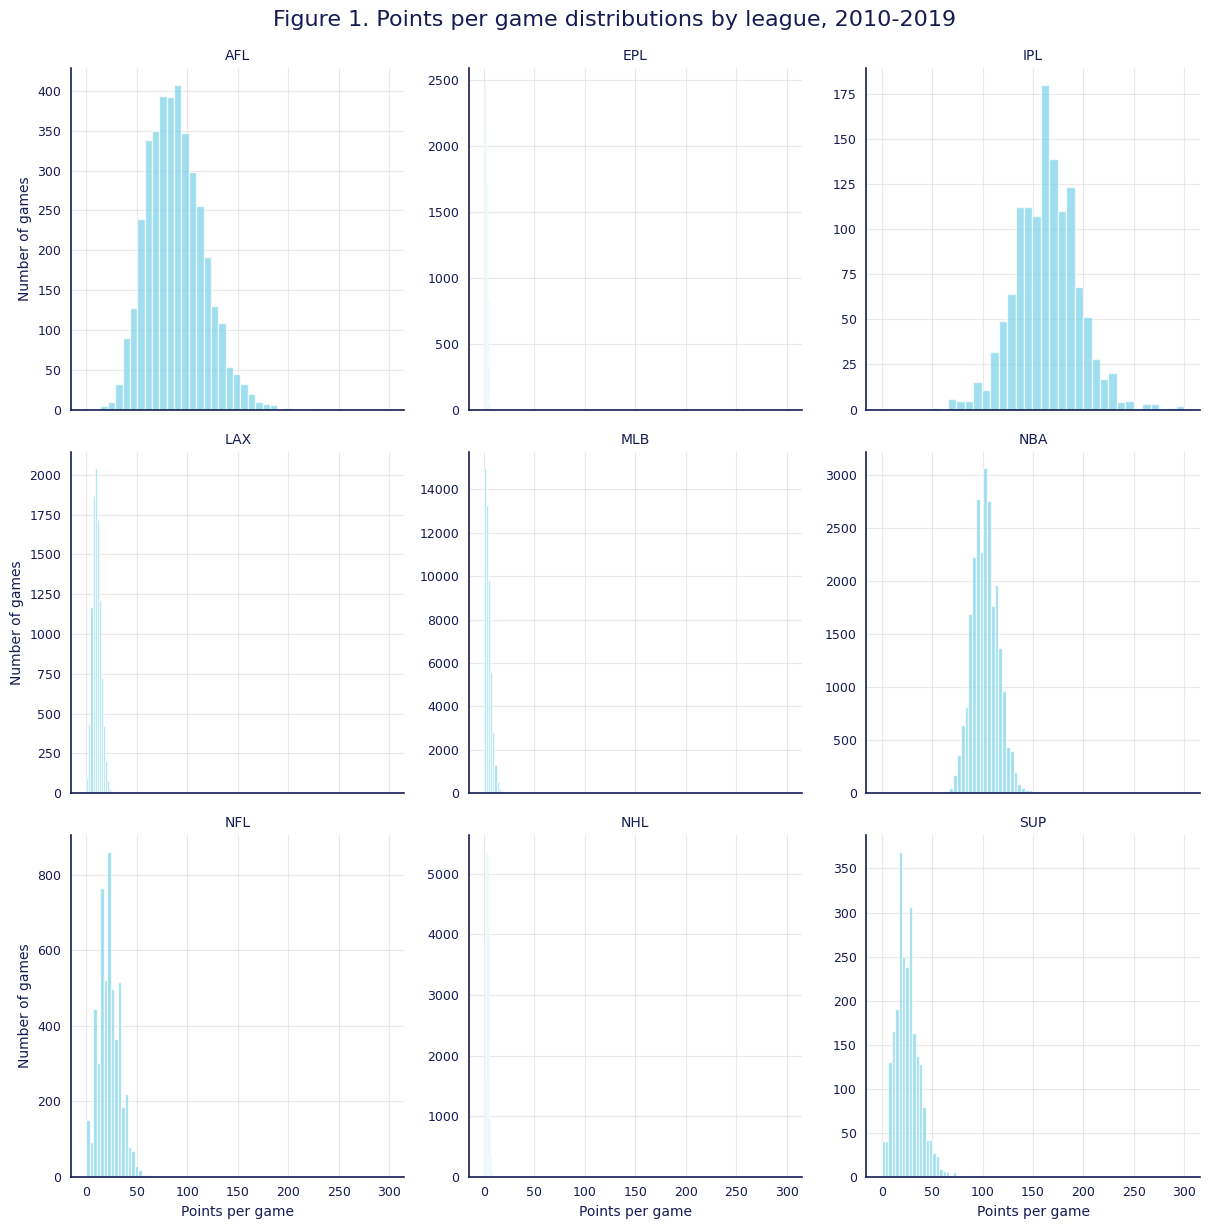

Exported: figure1_points_distributions.html


ValueError: dictionary update sequence element #0 has length 6; 2 is required

In [10]:
# Get points scored data for all games, 2010-2019 seasons  
lazy_dfs = league_data.read_batch(leagues, lazy=True)
lazy_dfs = lazy_dfs[(lazy_dfs['YEAR_ID']>=st_year_) & (lazy_dfs['YEAR_ID']<=end_year_)]
lazy_dfs = adb.concat(lazy_dfs)
points_data = lazy_dfs.collect().data[['LEAGUE', 'PS']]

# Define league order to match Figure 1 layout (3x3 grid, alphabetical)
league_order = ['AFL', 'EPL', 'IPL', 'LAX', 'MLB', 'NBA', 'NFL', 'NHL', 'SUP']

# Function to calculate optimal bins for each league
def get_optimal_bins(data, x_col, league):
    league_data = data[data['LEAGUE'] == league][x_col]
    data_range = league_data.max() - league_data.min()
    
    if data_range <= 15:  # Low-scoring sports (EPL, NHL)
        optimal_bins = min(15, int(data_range) + 1)
    elif data_range <= 50:  # Medium-scoring
        optimal_bins = min(25, int(data_range * 0.5))
    else:  # High-scoring sports
        optimal_bins = min(30, int(data_range * 0.3))
    
    return max(10, optimal_bins)  # Minimum 10 bins

# Create static seaborn histogram with faceting - Figure 1
grid = sns.FacetGrid(points_data, col='LEAGUE', col_wrap=3, col_order=league_order, 
                     height=4, aspect=1.0, sharey=False)

# Apply adaptive binning to each subplot
def plot_adaptive_hist(x, **kwargs):
    league = kwargs.get('label', 'Unknown')
    # Get current axes to determine which league we're plotting
    current_ax = plt.gca()
    title = current_ax.get_title()
    if '=' in title:
        league = title.split('=')[1].strip()
    
    optimal_bins = get_optimal_bins(points_data, 'PS', league)
    plt.hist(x, bins=optimal_bins, color=chart_colors['primary_color'], alpha=0.7)

grid.map(plot_adaptive_hist, 'PS')
grid.set_axis_labels('Points per game', 'Number of games')
grid.set_titles('{col_name}')
grid.fig.suptitle('Figure 1. Points per game distributions by league, 2010-2019', 
                  fontsize=16, y=1.02)

# Apply custom styling
for ax in grid.axes.flat:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color(chart_colors['secondary_color'])
        spine.set_linewidth(1.2)
    ax.tick_params(colors=chart_colors['text_color'], labelsize=9)
    ax.grid(True, color='#E0E0E0', linewidth=0.8, alpha=0.7)
    ax.set_axisbelow(True)

plt.show()

# Create and display interactive Plotly version with adaptive binning
fig = create_plotly_histplot(
    data=points_data,
    x_col='PS',
    col_col='LEAGUE',
    col_order=league_order,  # Same order as seaborn
    col_wrap=3,  # 3x3 grid layout
    title='Figure 1. Points per game distributions by league, 2010-2019',
    adaptive_bins=True  # Use adaptive binning to fix EPL/NHL gaps
)

# Update axis labels to match Figure 1
fig.update_xaxes(title_text="Points per game")
fig.update_yaxes(title_text="Number of games")

# Display interactive plot in notebook
fig.show()

# Export both HTML and JSON versions
export_plot(fig, "figure1_points_distributions", "Figure 1 - Points per game distributions")

In [ ]:
# points scored for all games
lazy_dfs = league_data.read_batch(leagues, lazy=True)
lazy_dfs = lazy_dfs[(lazy_dfs['YEAR_ID']>=st_year_) & (lazy_dfs['YEAR_ID']<=end_year_)]
lazy_dfs = adb.concat(lazy_dfs)
points_scored = lazy_dfs.collect().data[['LEAGUE', 'PS']]
style_table(points_scored)

### Figure 1 calculate points-scored stats
- check positive skew comment in text
- note need help to plot via python like r panel plot

In [ ]:
point_stats = points_scored.groupby(['LEAGUE']).agg(Mean=('PS', 'mean'),
                                             Std=('PS', 'std'),
                                             Skew=('PS', 'skew'),
                                             nobs=('PS', 'count'))
point_stats['IR']=point_stats['Mean']/point_stats['Std']
point_stats = point_stats.sort_values(['IR'])
style_table(point_stats.round(2), hide_index=False)

In [ ]:
# Create static seaborn catplot
grid = sns.catplot(point_stats.reset_index().melt(['LEAGUE']),
                   kind="bar",
                   x="LEAGUE",
                   y="value",
                   hue="LEAGUE",
                   col="variable",
                   col_wrap=3,
                   sharey=False)
grid.set_axis_labels("", "")
grid.set_titles("{col_name} (Points Scored)")

# Apply custom styling
style_catplot(grid, chart_colors)
plt.show()

# Create and display interactive Plotly version with same layout
fig = create_plotly_catplot(
    data=point_stats.reset_index().melt(['LEAGUE']),
    x_col="LEAGUE",
    y_col="value",
    hue_col="LEAGUE",
    col_col="variable",
    col_wrap=3,  # Same as seaborn version
    title="Figure 1. Points Scored Statistics by League",
    sharey=False
)

# Display interactive plot in notebook
fig.show()

# Export both HTML and JSON versions
export_plot(fig, "point_stats_catplot", "Points Scored Statistics")

### Save into ArcticDB

In [ ]:
analysis = arctic.get_library('analysis', create_if_missing=True)
analysis.write('point_stats', point_stats)

### Regress points against wins
set up data for regression by aggregating by league-team-season

In [ ]:
lazy_dfs = league_data.read_batch(leagues, lazy=True)
df = adb.concat(lazy_dfs).collect().data[['LEAGUE','YEAR_ID','TEAM_ID','PS','PA','wi']]
df_team = df.groupby(['LEAGUE','YEAR_ID','TEAM_ID']).agg(PS=('PS', 'mean'),
                                                         PA=('PA', 'mean'),
                                                         wi=('wi', 'mean'),
                                                         nobs=('wi', 'count'))
style_table(df_team.round(2).head(),hide_index=False)

### Figure 2 -- NBA and EPL

In [ ]:
# prepare data for regression
df_reg = df_team.copy()
df_reg = df_reg.loc[(df_reg['PS']>0) & (df_reg['PA']>0) & (df_reg['wi']>0) & (df_reg['wi']<1)]
df_reg['lnwi']=np.log(df_reg['wi']/(1-df_reg['wi']))
df_reg['lnPSPA']=np.log(df_reg['PS']/df_reg['PA'])
df_reg = df_reg.reset_index()

# Create static seaborn plot
NBA_and_EPL = df_reg[df_reg['LEAGUE'].isin(['NBA', 'EPL'])]
grid = sns.lmplot(data=NBA_and_EPL,
           x='lnPSPA',
           y='lnwi',
           hue='LEAGUE',
           scatter_kws=dict(s=3),
           line_kws=dict(color="grey"),
           facet_kws=dict(legend_out=False),
           aspect=1.6)

# Apply custom styling
style_lmplot(grid, chart_colors)

plt.title('Figure 2. Team-Season Plot: EPL (1888-89 to 2018-19) & NBA (1946-47 to 2018-19)')
plt.xlabel('log(PSi / PAi)')
plt.ylabel('log(Wi / Li)')
plt.show()

# Create and display interactive Plotly version
fig = create_plotly_scatterplot(
    data=NBA_and_EPL,
    x_col='lnPSPA',
    y_col='lnwi', 
    hue_col='LEAGUE',
    title='Figure 2. Team-Season Plot: EPL (1888-89 to 2018-19) & NBA (1946-47 to 2018-19)',
    show_regression=True
)

# Display interactive plot in notebook
fig.show()

# Export both HTML and JSON versions
export_plot(fig, "team_season_plot", "Team-Season Analysis")

In [ ]:
# Compute standard regression results by team-season for 2010-19 period
df_ols = df_reg.loc[(df_reg['YEAR_ID']>=st_year_) & (df_reg['YEAR_ID']<=end_year_)]
ols=df_ols.groupby(['LEAGUE']).apply(ols_coef,xcol=['lnPSPA'],ycol=['lnwi'])
ols = ols.droplevel(1).sort_values(['λ']).reset_index().round(2)
style_table(ols, hide_index=False)

### Save into ArcticDB

In [ ]:
analysis.write('ols', ols);

### Figure 3a -- 2010 to 2019

In [ ]:
# Create static seaborn catplot
grid = sns.catplot(ols.melt(['LEAGUE']),
                   kind="bar",
                   x="LEAGUE",
                   y="value",
                   hue="LEAGUE",
                   col="variable",
                   col_order=["λ", "nobs", "adj. $R^2$"],
                   sharey=False)
grid.set_axis_labels("", "")
grid.set_titles("{col_name}")

# Apply custom styling
style_catplot(grid, chart_colors)

# add error bars to λ
axis = grid.facet_axis(0, 0, True)
axis.errorbar(ols['LEAGUE'], ols['λ'], yerr=ols['λ se']*2, fmt="none", capsize=5, color="r")
# add labels to R^2
axis = grid.facet_axis(0, 2, True)
[axis.bar_label(c, fontsize=10) for c in axis.containers]
plt.show()

# Prepare data for interactive Plotly version with error bars
ols_melted = ols.melt(['LEAGUE'])
# Add error column - only λ has error bars (2 * standard error)
ols_melted['error'] = ols_melted.apply(lambda row: 
    ols.loc[ols['LEAGUE'] == row['LEAGUE'], 'λ se'].iloc[0] * 2 
    if row['variable'] == 'λ' else None, axis=1)

# Create and display interactive Plotly version
fig = create_plotly_catplot(
    data=ols_melted,
    x_col="LEAGUE",
    y_col="value",
    hue_col="LEAGUE",
    col_col="variable",
    col_order=["λ", "nobs", "adj. $R^2$"],
    title="Figure 3a. OLS Results by League, 2010-2019 Seasons",
    sharey=False,
    error_col="error",
    add_value_labels=True  # Show values on R^2 bars like the seaborn version
)

# Display interactive plot in notebook
fig.show()

# Export both HTML and JSON versions
export_plot(fig, "ols_results_catplot", "OLS Results by League")

In [ ]:
bar_width = 0.4
x = np.arange(len(ols['LEAGUE']))

# First chart - Lambda estimates
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(ols['LEAGUE'], ols['λ'], bar_width, 
              color=chart_colors['primary_color'], label='OLS')
ax.errorbar(ols['LEAGUE'], ols['λ'], yerr=ols['λ se']*2, 
            fmt="none", capsize=5, color=chart_colors['accent_color'])
style_matplotlib_chart(ax, chart_colors, 'Figure 3a. Estimates of λ by League, 2010-2019 Seasons')
plt.show()

# Second chart - Number of Observations
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(ols['LEAGUE'], ols['nobs'], 
              color=chart_colors['secondary_color'])
style_matplotlib_chart(ax, chart_colors, 'Figure 3a. Number of Obs by League, 2010-2019 Seasons')
plt.show()

# Third chart - Adjusted R-squared
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(ols['LEAGUE'], ols['adj. $R^2$'], 
              color=chart_colors['accent_color'])
ax.bar_label(bars, fmt='%.2f', color=chart_colors['text_color'])
style_matplotlib_chart(ax, chart_colors, 'Figure 3a. James Model Adj Rsq by League, 2010-2019 Seasons')
plt.show()

# Create and display interactive Plotly versions

# 1. Lambda estimates with error bars
fig1 = create_plotly_bar_chart(
    data=ols,
    x_col='LEAGUE',
    y_col='λ',
    title='Figure 3a. Estimates of λ by League, 2010-2019 Seasons',
    error_col='λ se',  # Error bars (will be multiplied by 2 in the function)
    add_value_labels=False
)
# Multiply error bars by 2 to match matplotlib version
fig1.data[0].error_y.array = fig1.data[0].error_y.array * 2
fig1.show()
export_plot(fig1, "lambda_estimates", "Lambda Estimates by League")

# 2. Number of observations
fig2 = create_plotly_bar_chart(
    data=ols,
    x_col='LEAGUE',
    y_col='nobs',
    title='Figure 3a. Number of Obs by League, 2010-2019 Seasons',
    add_value_labels=False
)
# Use secondary color
fig2.data[0].marker.color = colors['secondary_color']
fig2.show()
export_plot(fig2, "number_observations", "Number of Observations by League")

# 3. Adjusted R-squared with value labels
fig3 = create_plotly_bar_chart(
    data=ols,
    x_col='LEAGUE',
    y_col='adj. $R^2$',
    title='Figure 3a. James Model Adj Rsq by League, 2010-2019 Seasons',
    add_value_labels=True
)
# Use accent color
fig3.data[0].marker.color = colors['accent_color']
fig3.show()
export_plot(fig3, "adjusted_rsquared", "Adjusted R-squared by League")

In [ ]:
# calculate mean league IRs group by league-season
df_leagueM = df[['LEAGUE','YEAR_ID','PS','PA','wi']].groupby(['LEAGUE','YEAR_ID']).mean()
df_leagueS = df[['LEAGUE','YEAR_ID','PS','PA','wi']].groupby(['LEAGUE','YEAR_ID']).std()
df_leagueIR = df_leagueM['PS']/df_leagueS['PS']
df_leagueIR = df_leagueIR.reset_index().rename(columns={'PS': 'IR'})

# calc 10 year average for 2010-2019
df_leagueIR10 = df_leagueIR.loc[(df_leagueIR['YEAR_ID']>=st_year_) & (df_leagueIR['YEAR_ID']<=end_year_)]
df_leagueIR10 = df_leagueIR10[['LEAGUE','IR']].groupby(['LEAGUE']).mean()
df_leagueIR10 = df_leagueIR10.reset_index().rename(columns={'IR': 'IR10'})
df_leagueIR10 = df_leagueIR10.merge(ols, how='left', on=['LEAGUE'])

# Create static matplotlib scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x=df_leagueIR10['IR10'], y=df_leagueIR10['λ'], 
          color=chart_colors['primary_color'], s=80, alpha=0.7)

# Fit a linear regression model
model=sm.OLS(df_leagueIR10['λ'],sm.add_constant(df_leagueIR10['IR10'])).fit()    

# Plot the regression line
ax.plot(df_leagueIR10['IR10'], model.predict(), 
        color=chart_colors['secondary_color'], linewidth=2, alpha=0.8)

# Add labels to the data points
for i in range(len(df_leagueIR10)):
    ax.text(df_leagueIR10['IR10'].iloc[i], df_leagueIR10['λ'].iloc[i], 
           f"{df_leagueIR10['LEAGUE'].iloc[i]}", 
           fontsize=9, ha='center', va='bottom',
           color=chart_colors['text_color'])
    
ax.set_xlabel('League Information Ratio (Average of League Annual IRs 2010-2019)') 
ax.set_ylabel('Fitted λ')
ax.set_xlim(0,9)
ax.set_ylim(0,16)

# Apply custom styling
style_matplotlib_chart(ax, chart_colors, 'Figure 3b. Estimates of λ vs. League Information Ratio, 2010-2019 Seasons')
plt.show()

# Create and display interactive Plotly version
fig = create_plotly_scatterplot(
    data=df_leagueIR10,
    x_col='IR10',
    y_col='λ',
    title='Figure 3b. Estimates of λ vs. League Information Ratio, 2010-2019 Seasons',
    show_regression=True,
    text_col='LEAGUE',  # Add league labels to data points
    xlim=(0, 9),        # Match matplotlib axis limits
    ylim=(0, 16)
)

# Display interactive plot in notebook
fig.show()

# Export both HTML and JSON versions
export_plot(fig, "lambda_vs_information_ratio", "Lambda vs Information Ratio")